# Project 1: The Basics

This is a sample end-to-end data-science/machine-learning project to illustrate the basic concepts using a real-world dataset, including data exploration, preprocessing, and model training, selection and fine-tuning. It was inspired by Chapter 2 of *Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow*, 2nd Edition, by Aurélien Géron (O'Reilly); copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.

## Introduction

The goal of this project is to build a model that can reliably predict the median housing price in any census block group (hereafter "district") in California. We will use the California Housing Prices dataset to train the model. This dataset is based on data from the 1990 California census and contains metrics such as the population per district, median household income, median housing price, and so on. This is an old dataset, but it is for illustrative purposes only.

Let's suppose that the business objective of this project is to have our model's output (that is, its prediction of a district's median housing price) used as input to another machine-learning system that determines if it is worth investing in a given area or not. Furthermore, let's imagine that the business is currently estimating the district housing prices manually by some complex set of rules and that these estimates are often off by more than 20%. Our model should therefore be

1. less costly than performing these estimates manually (this should be a given), and
2. outperform the manual estimates as measured by the accuracy of the model's prediction.

## System Requirements

In [67]:
# Required Python version
import sys

assert sys.version_info >= (3, 7)

# Required Scikit-Learn version
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Import the common libraries
import numpy as np
import pandas as pd

print(f"System requirements check: Success. Using Python version {sys.version} and sklearn version {sklearn.__version__}")

System requirements check: Success. Using Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] and sklearn version 1.4.1.post1


## Get the Data

The dataset is available as a csv file from the URL in the code snippet below:

In [68]:
from pathlib import Path
import tarfile
import urllib.request

def load_housing_data(datasets_root_dir="datasets"):
    """Fetch and/or load the California Housing Prices dataset and return as a
    pandas DataFrame.

    The dataset is loaded from file '<datasets_root_dir>/housing/housing.csv'.
    If this csv file does not already exist, the dataset is downloaded from:

        https://github.com/ageron/data/raw/main/housing.tgz.

    Parameters
    ----------
    datasets_root_dir : str, optional
        Root directory where datasets will be saved to disk, by default "datasets".

    Returns
    -------
    pandas.DataFrame
        DataFrame containing the California Housing Prices dataset.
    """
    datasets_root_path = Path(datasets_root_dir)
    datasets_root_path.mkdir(parents=True, exist_ok=True)

    csv_path = datasets_root_path / Path("housing/housing.csv")

    if not csv_path.is_file():
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        tarball_path = datasets_root_path / Path("housing.tgz")

        print(f"Downloading housing dataset from {url}...")
        urllib.request.urlretrieve(url, tarball_path)

        print(f"Extracting data to file '{csv_path}'")
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path=datasets_root_path)

    print(f"Loading dataset from file '{csv_path}'")
    return pd.read_csv(csv_path)

In [69]:
housing = load_housing_data()

Loading dataset from file 'datasets/housing/housing.csv'


## Data Exploration

Let's look at the dataset we're working with:

In [70]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [71]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We have 20,640 instances in the dataset and ten attributes, or *features*. First, notice that there are only 20,433 non-null values for the `total_bedrooms` field, meaning that there are 207 districts missing this feature; we'll address this later. Second, all of these features are numerical except for `ocean_proximity`, which is stored as plain text to represent a certain category describing the district's proximity to the ocean. The possible values that this feature can take, and the respective number of instances in the dataset are:

In [72]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Now let's look at a summary and histogram of each numerical feature to understand how they are distributed:

In [73]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


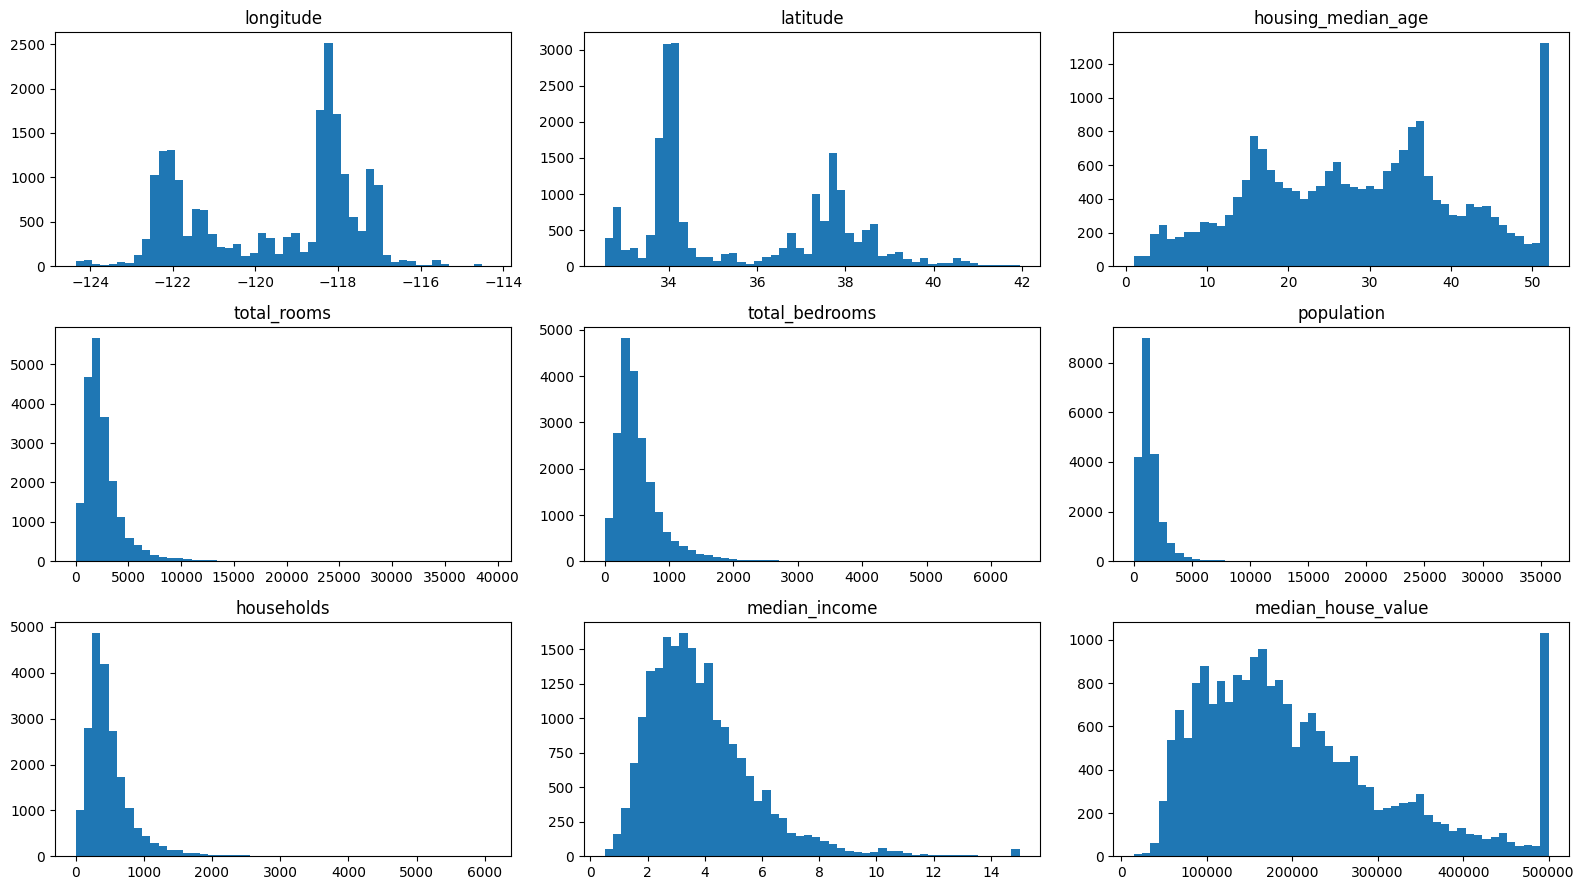

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(16, 9), grid=False)
plt.tight_layout()
plt.show()

The summary and histograms reveal a few important things about this dataset:

1. The median income ranges from 0.49990 to 15.00010, so surely it does not represent values in USD, or any other currency for that matter. It turns out this feature was scaled in such a way that 1 unit is approximately equal to $10,000, and capped at 15 (~$150,000).
2. The median age and median house value were also capped, at 52 and $500,001, respectively. Having the median house value capped may pose a serious problem since this is the target feature we are trying to predict. If we train the model on the raw values, it might learn that house values never exceed $500,000. We have two options:
    1. Collect proper data for the districts whose values were capped (however this is not feasible in the context of this project), or
    2. Remove these districts from the dataset.

3. These features have very different scales, in absolute terms, and their distributions are not symmetric. Therefore, they may require some feature scaling, depending on the model(s) we choose to train.

Let's remove the districts with capped values now.

In [75]:
capped_value_filter_idx = (
    (housing["median_house_value"] < 500001) &
    (housing["median_income"] < 15.0001) &
    (housing["housing_median_age"] < 52)
)
housing = housing.loc[capped_value_filter_idx].copy()

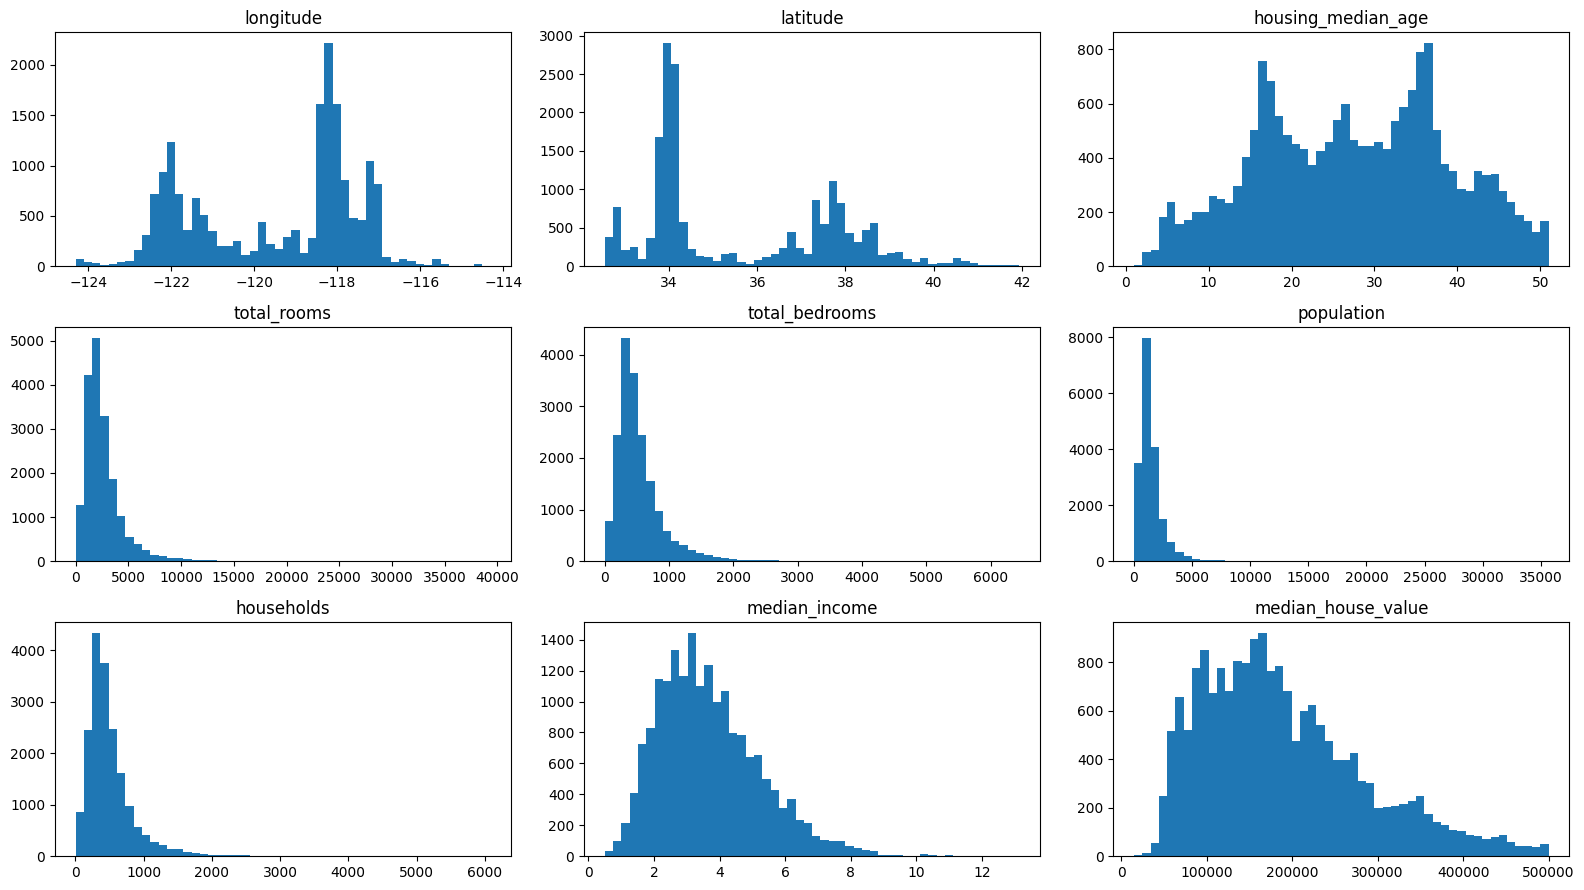

In [76]:
housing.hist(bins=50, figsize=(16, 9), grid=False)
plt.tight_layout()
plt.show()

In [77]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,18570.000000,18570.000000,18570.000000,18570.000000,18377.000000,18570.000000,18570.000000,18570.000000,18570.000000
mean,-119.484663,35.593033,26.985245,2669.114970,548.062252,1470.549058,508.775444,3.692044,189587.641195
std,1.980805,2.147740,11.430958,2223.792693,429.418391,1162.909643,389.553371,1.565738,95775.718356
min,-124.300000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.550000,33.920000,17.000000,1455.000000,300.000000,811.000000,284.000000,2.537225,115400.000000
50%,-118.450000,34.240000,27.000000,2142.000000,442.000000,1203.000000,416.000000,3.467750,171200.000000
75%,-117.970000,37.670000,36.000000,3184.000000,659.000000,1781.000000,614.000000,4.615300,243200.000000
max,-114.310000,41.950000,51.000000,39320.000000,6445.000000,35682.000000,6082.000000,13.147700,500000.000000


We had 20,640 instances (districts) initially, so we have dropped 2070 instances in total, or about 10% of the dataset.

## Create a Training and Test Set

Before we go any further, let's separate the dataset into a training set and a test set.

Let's imagine that our California housing experts have told us that median income is a very important attribute to predict median housing prices. In that case, we will want to ensure that the test set is representative of the distribution of median incomes over the full dataset. One approach to achieve this is to create our training and test sets using *stratified sampling* by defining a few median income bins and filling the test set in such a way that the proportion of instances in each bin are approximately equal in the test set and the full dataset.

First, we'll create a new feature in the dataset called `income_cat` to categorize the median income in bins from 0 to 6 (where most of the data lie) with a step size of 1.5, and a final category for districts with a medium income greater than 6:

In [78]:
income_cat_bins = [0.0, 1.5, 3.0, 4.5, 6.0, np.inf]

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=income_cat_bins,
    labels=[1, 2, 3, 4, 5]
)

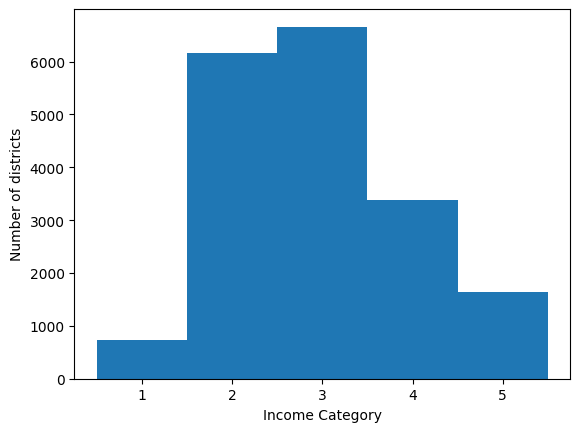

In [79]:
plt.hist(housing["income_cat"], np.arange(0.5, 6.5))
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [80]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(splitter.split(housing, housing["income_cat"]))

housing_train = housing.iloc[train_index]
housing_test = housing.iloc[test_index]

Let's quickly double-check that this worked as expected:

In [81]:
# Create a dataframe containing proportion of districts per income category for
# both the full set and the test set; also compute relative percent error
df_income_cat_dist = pd.DataFrame({
    "full_set": housing["income_cat"].value_counts() / len(housing),
    "test_set": housing_test["income_cat"].value_counts() / len(housing_test)
})
df_income_cat_dist["relative_error_percent"] = ((df_income_cat_dist["test_set"] / df_income_cat_dist["full_set"]) - 1) * 100
df_income_cat_dist.sort_index(inplace=True)
df_income_cat_dist

,full_set,test_set,relative_error_percent
income_cat,,,
1,0.039580,0.039580,0.000000
2,0.331879,0.331718,-0.048678
3,0.358643,0.358643,0.000000
4,0.181637,0.181745,0.059294
5,0.088261,0.088314,0.061013


The relative errors are all reasonably small (<0.1%), confirming that the test set is representative of the full dataset in terms of the proportion of districts per income category. 

Now that we've created the training and test sets, we'll drop the `"income_cat"` feature, since we don't want it included when we train the model.

In [82]:
housing_train = housing_train.drop("income_cat", axis=1)
housing_test = housing_test.drop("income_cat", axis=1)

## Visualizing the Dataset

Let's plot the dataset as a geographical scatter plot. We'll set the marker size proportional to the population of the district and visualize the house value using a colour map, ranging from blue (low values) to red (high values). We will only look at the training set from here on out.

In [83]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_scatter_on_map(data, s_key="", s_label="", c_key="", c_label="", c_formatter=""):
    """Plot the provided data on a map.

    The `data` parameter should be a pandas DataFrame containing columns
    "longitude" and "latitude". If `s_key` is provided, the values in data[s_key]
    are used for the scatter plot marker size. If `c_key` is provided, the values
    in data[c_key] are used for the scatter plot marker colour.
    """
    plt.figure(figsize=(8, 6))

    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add features to the map
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    # ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.STATES, edgecolor="gray", linestyle="--")

    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=["left", "bottom"], linewidth=0.1)

    plt.scatter(
        data["longitude"],
        data["latitude"],
        alpha=0.4,
        s=data[s_key] * 0.02,
        c=data[c_key] * 0.001,
        edgecolors="None",
        cmap=plt.get_cmap("jet"),
        label=s_label,
        transform=ccrs.PlateCarree(),
        zorder=10
    )
    cbar = plt.colorbar(label=c_label)

    if c_formatter:
        cbar.ax.yaxis.set_major_formatter(c_formatter)

    plt.legend()

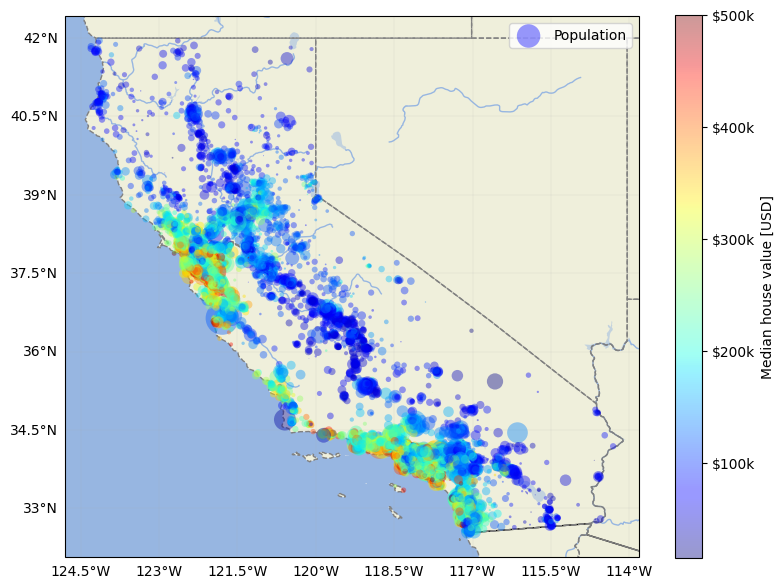

In [84]:
plot_scatter_on_map(
    housing_train,
    s_key="population",
    s_label="Population",
    c_key="median_house_value",
    c_label="Median house value [USD]",
    c_formatter="${x:3.0f}k"
)
plt.tight_layout()
plt.show()

This image confirms what we probably already guessed, that housing prices are very much related to the location, and that high housing prices are found in the large cities. The "proximity-to-the-ocean" feature might prove useful, since the majority of the high housing prices are along the coast, although there are exceptions to this pattern along the coast of northern California.

Let's now see if we can identify any other correlations in the dataset.

## Looking for Correlations

First let's look at the correlation matrix for each numerical feature:

In [85]:
housing_corr_matrix = housing_train.corr(numeric_only=True)
housing_corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.923473,-0.031573,0.033204,0.062540,0.091289,0.049197,-0.015114,-0.022902
latitude,-0.923473,1.000000,-0.053098,-0.021975,-0.058981,-0.105471,-0.066011,-0.075075,-0.170097
housing_median_age,-0.031573,-0.053098,1.000000,-0.373654,-0.332025,-0.286059,-0.312313,-0.200594,0.012824
total_rooms,0.033204,-0.021975,-0.373654,1.000000,0.934957,0.864403,0.920025,0.227645,0.153876
total_bedrooms,0.062540,-0.058981,-0.332025,0.934957,1.000000,0.886722,0.977238,0.024065,0.079323
population,0.091289,-0.105471,-0.286059,0.864403,0.886722,1.000000,0.918431,0.044887,0.022504
households,0.049197,-0.066011,-0.312313,0.920025,0.977238,0.918431,1.000000,0.049023,0.099333
median_income,-0.015114,-0.075075,-0.200594,0.227645,0.024065,0.044887,0.049023,1.000000,0.666813
median_house_value,-0.022902,-0.170097,0.012824,0.153876,0.079323,0.022504,0.099333,0.666813,1.000000


The features most strongly correlated with median house value are, in descending order:

In [86]:
housing_corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.666813
total_rooms           0.153876
households            0.099333
total_bedrooms        0.079323
population            0.022504
housing_median_age    0.012824
longitude            -0.022902
latitude             -0.170097
Name: median_house_value, dtype: float64

Let's plot a few of the top features:

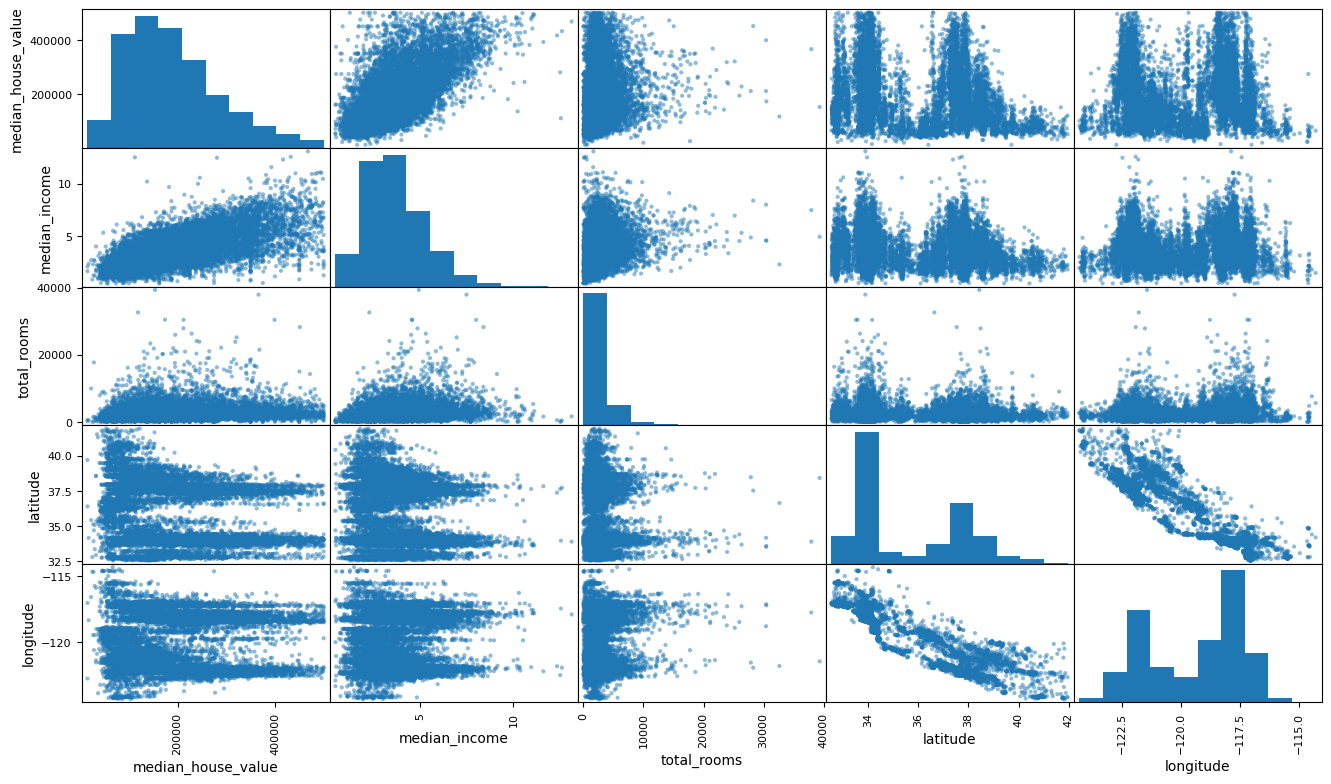

In [87]:
attributes = ["median_house_value", "median_income", "total_rooms", "latitude", "longitude"]
pd.plotting.scatter_matrix(housing_train[attributes], figsize=(16, 9))
plt.show()

We can see clearly now the correlation between median house value and median income. Let's zoom in on this plot: 

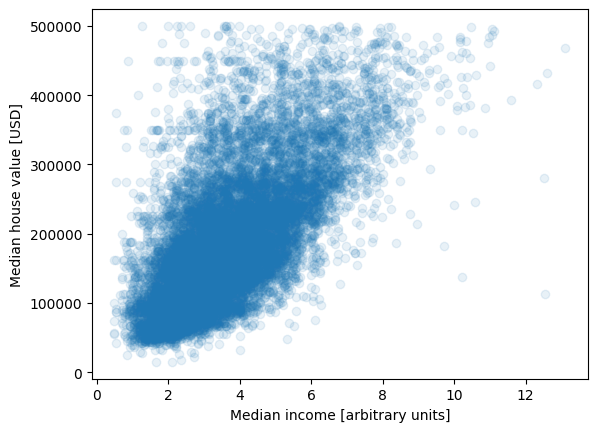

In [22]:
plt.scatter(housing_train["median_income"], housing_train["median_house_value"], alpha=0.1)
plt.xlabel("Median income [arbitrary units]")
plt.ylabel("Median house value [USD]")
plt.show()

The correlation is clearly visible, despite the noisiness of the data. However, this plot also reveals a few quirks in the data: there are a number of other horizontal lines visible in the data, at approximately $450k, $350k, and a few others.

Let's list out these horizontal lines:

In [23]:
unique_elements, counts = np.unique(np.sort(housing_train["median_house_value"]), return_counts=True)

unique_elements_idx = counts >= 10
repeating_elements = unique_elements[unique_elements_idx]
repetition_counts = counts[unique_elements_idx]

pd.DataFrame({"median_house_value": repeating_elements, "n_repetitions": repetition_counts})

,median_house_value,n_repetitions
0,55000.0,21
1,57500.0,11
2,62000.0,11
3,67500.0,40
4,70000.0,10
...,...,...
203,362500.0,12
204,375000.0,13
205,400000.0,12
206,450000.0,24


In [24]:
diff = np.diff(np.sort(housing_train["median_house_value"]))
diff[diff > 0][-12:]  # Last N elements

array([ 200.,  100.,  100.,  400., 1000.,  200., 1000.,  100.,  100.,
        200.,  100.,  900.])

In [25]:
np.min(diff[diff > 1])

100.0

It looks like the median house value has been rounded to the nearest $100, which would explain the horizontal lines. Perhaps in some districts where the housing price is close to $450k, for example, it has been rounded to the nearest $100, while for others it may have been rounded to the nearest $1000; without knowing how the data was collected, it's hard to say.

While we're here, let's look for repetitions in the median income data as well:

In [26]:
unique_elements, counts = np.unique(np.sort(housing_train["median_income"]), return_counts=True)

unique_elements_idx = counts >= 15
repeating_elements = unique_elements[unique_elements_idx]
repetition_counts = counts[unique_elements_idx]

pd.DataFrame({"median_income": repeating_elements, "n_repetitions": repetition_counts})

,median_income,n_repetitions
0,1.6250,18
1,1.8750,15
2,2.1250,23
3,2.2500,22
4,2.3750,23
5,2.5000,22
6,2.6250,35
7,2.7500,19
8,2.8750,33
9,3.0000,32


The repeating values appear to be an artifact of the median incomes being in step sizes of 1/16 = 0.0625, which in these units is approximately $625 USD.

In [27]:
np.linspace(0, 1, 17)

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    ])

We'll handle data cleanup later.

## Experimenting with Feature Combinations

We can try combining multiple features into a new feature to see if this new feature is strongly correlated with median house values. A good candidate is to compute the number of rooms per household, since individually the total number of rooms and number of households per district are intuitively not good predictors of a district's median house value. Other candidates worth trying are number of bedrooms per household, population per household, the ratio of bedrooms to rooms, etc.

In [28]:
housing_train["rooms_per_household"] = housing_train["total_rooms"] / housing_train["households"]
housing_train["bedrooms_per_household"] = housing_train["total_bedrooms"] / housing_train["households"]
housing_train["population_per_household"] = housing_train["population"] / housing_train["households"]
housing_train["bedrooms_per_room"] = housing_train["total_bedrooms"] / housing_train["total_rooms"]

In [29]:
housing_train.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.666813
total_rooms                 0.153876
rooms_per_household         0.113146
households                  0.099333
total_bedrooms              0.079323
population                  0.022504
housing_median_age          0.012824
population_per_household   -0.018519
longitude                  -0.022902
bedrooms_per_household     -0.059655
latitude                   -0.170097
bedrooms_per_room          -0.238348
Name: median_house_value, dtype: float64

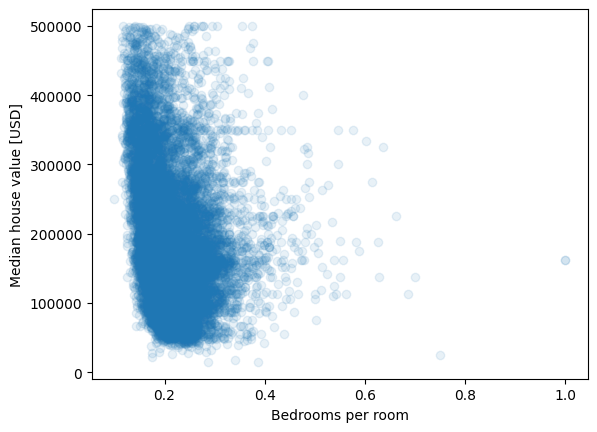

In [30]:
plt.scatter(housing_train["bedrooms_per_room"], housing_train["median_house_value"], alpha=0.1)
plt.xlabel("Bedrooms per room")
plt.ylabel("Median house value [USD]")
plt.show()

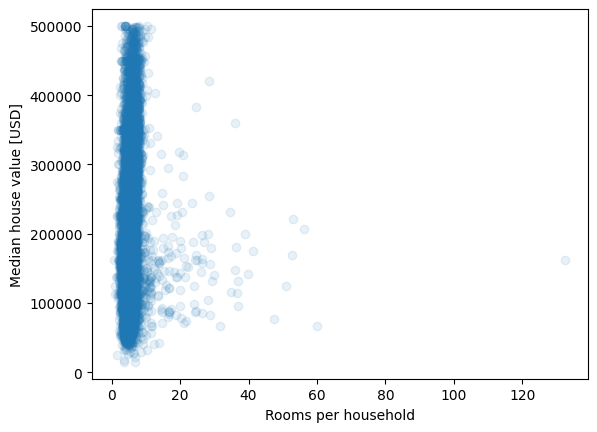

In [31]:
plt.scatter(housing_train["rooms_per_household"], housing_train["median_house_value"], alpha=0.1)
plt.xlabel("Rooms per household")
plt.ylabel("Median house value [USD]")
plt.show()

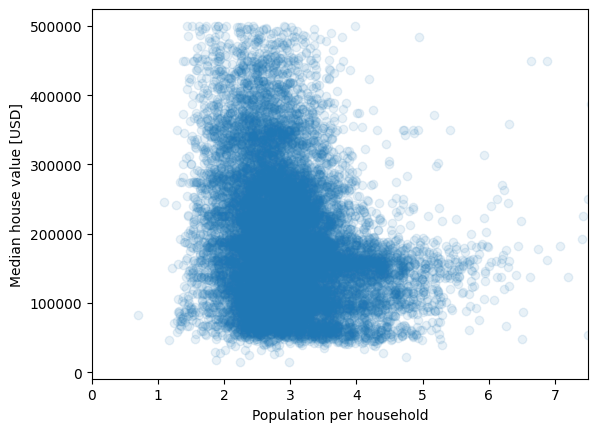

In [32]:
plt.scatter(housing_train["population_per_household"], housing_train["median_house_value"], alpha=0.1)
plt.xlabel("Population per household")
plt.ylabel("Median house value [USD]")
plt.xlim(0, 7.5)
plt.show()

We can see from these correlation coefficients that a district's median house value is still most strongly correlated with the median income in that district. However, one of our new features, number of bedrooms per room, is the next most strongly (anti) correlated with median house value, suggesting that houses with a lower bedroom/room ratio tend to be more expensive. We can also see that the number of rooms per household is a slightly better predictor of median house value that either the total rooms or number of households in a district individually. The other new features are not strongly correlated with median house value.

## Data Preparation

Let's first clean the dataset, starting from a fresh copy of the training set. We'll drop the labels from the training set (i.e., the median house value) and store it in a separate data structure.

In [33]:
housing_train = housing.iloc[train_index].drop("median_house_value", axis=1).copy()
housing_train_labels = housing["median_house_value"].iloc[train_index].copy()

In [34]:
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
13456,-121.54,38.54,36.0,1672.0,302.0,969.0,337.0,3.0536,INLAND,3
15179,-117.91,34.12,41.0,2673.0,578.0,2259.0,592.0,3.7846,<1H OCEAN,3
4270,-117.34,34.10,14.0,11827.0,2445.0,6640.0,2299.0,2.4878,INLAND,2
12268,-122.31,38.27,34.0,1748.0,284.0,783.0,303.0,4.3585,NEAR BAY,3
11100,-121.57,37.02,17.0,2889.0,624.0,2681.0,608.0,2.9417,INLAND,2


In [35]:
housing_train_labels.head()

13456     73100.0
15179    145500.0
4270     103800.0
12268    194400.0
11100    178000.0
Name: median_house_value, dtype: float64

We'll create a transformation pipeline to handle the data preparation. Since we have both numerical and categorical data, we'll use a `ColumnTransformer` to apply the appropriate transformation pipeline to the corresponding columns in the dataset.

For the numerical data, we will do the following:

1. We mentioned above that there are missing values for the total number of bedrooms feature. We'll use a simple imputer to fill in the missing values with the median of the feature.
2. We'll add our new features `rooms_per_household`, `bedrooms_per_room` and `population_per_household` since they are correlated with the median house values.
3. We'll apply standardization feature scaling to have each feature on the same scale (mean of 0 and variance of 1).

For the categorical data (ocean proximity), we will use a one-hot encoder, which adds a new feature for each possible value of the `ocean_proximity` feature, and then for each instance, sets the corresponding feature to 1 if it belongs to that category and to 0 for all the other features.

Let's put this all together:

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

# Numeric data pipeline step 2: Create a class to add new features

# Get the column indices
col_names = ["total_rooms", "total_bedrooms", "population", "households"]
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c in col_names]

class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        # Adding add_bedrooms_per_room as a hyperparameter will make it easier
        # to tell if this feature improves the ML model we train
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        # Nothing to do
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Build the transformation pipeline for the numeric data pipeline
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("feature_adder", CombinedFeaturesAdder()),
    ("std_scaler", StandardScaler())
])

# Build the transformation pipeline for the categorical data pipeline
categorical_pipeline = Pipeline([
    ("onehot_encoder", OneHotEncoder())
])

In [38]:
# Separate out the numeric features
housing_train_num = housing_train.select_dtypes(include=[np.number])

In [39]:
# Combine the two pipelines into a single ColumnTransformer pipeline
numeric_features = list(housing_train_num)
categorical_features = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Create a dataset with all the transformations applied
housing_train_preprocessed = full_pipeline.fit_transform(housing_train)

In [40]:
pd.DataFrame(housing_train_preprocessed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.037628,1.369791,0.790091,-0.447493,-0.575316,-0.441265,-0.443423,-0.407159,-0.182001,-0.021927,-0.578541,0.0,1.0,0.0,0.0,0.0
1,0.795349,-0.686277,1.228201,0.003069,0.076605,0.700887,0.221786,0.057912,-0.368578,0.056107,0.035322,1.0,0.0,0.0,0.0,0.0
2,1.083172,-0.695580,-1.137595,4.123394,4.486520,4.579774,4.674770,-0.767128,-0.105489,-0.020861,-0.128528,0.0,1.0,0.0,0.0,0.0
3,-1.426442,1.244194,0.614847,-0.413284,-0.617833,-0.605947,-0.532117,0.423033,0.155660,-0.046089,-0.891392,0.0,0.0,0.0,1.0,0.0
4,-1.052777,0.662727,-0.874729,0.100293,0.185258,1.074521,0.263525,-0.478351,-0.269715,0.105363,0.031104,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14851,-0.992182,1.369791,0.965335,-0.360621,-0.381630,-0.367778,-0.399075,-1.211649,-0.053662,-0.013930,-0.142873,0.0,1.0,0.0,0.0,0.0
14852,1.219510,-1.332868,-0.787106,0.135852,0.260843,-0.281895,0.193091,-0.666988,-0.120532,-0.096413,0.117847,0.0,0.0,0.0,0.0,1.0
14853,-1.522382,1.006956,1.841556,-0.566322,-0.591851,-0.510325,-0.620811,0.088895,-0.067945,0.014322,-0.080496,0.0,0.0,0.0,0.0,1.0
14854,0.800399,-0.704884,0.439603,1.267434,1.666253,1.734135,1.591333,-0.254023,-0.204427,-0.006015,0.241555,1.0,0.0,0.0,0.0,0.0


## Select and Train a Model

We'll try training a few candidate models and quickly evaluate their performance using K-folds cross-validation before selecting a final model and fine-tuning it.

In [41]:
from sklearn.model_selection import cross_val_score

### Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(housing_train_preprocessed, housing_train_labels)

LinearRegression()

In [43]:
from sklearn.metrics import mean_squared_error

linear_reg_rmse = np.sqrt(mean_squared_error(housing_train_labels, linear_reg.predict(housing_train_preprocessed)))
linear_reg_rmse

57528.93496210081

In [44]:
linear_reg_scores = cross_val_score(
    linear_reg,
    housing_train_preprocessed,
    housing_train_labels,
    scoring="neg_mean_squared_error",  # Use negative MSE to evaluate performance
    cv=10                              # Specify number of folds
)

def display_rmse_scores(mse_scores):
    rmse_scores = np.sqrt(-mse_scores)
    print(f"RMSE scores:\n{rmse_scores}")
    print(f"Mean:          {rmse_scores.mean()}")
    print(f"Std deviation: {rmse_scores.std()}")

display_rmse_scores(linear_reg_scores)

RMSE scores:
[58304.72979744 59343.52155836 58679.86211443 57613.20453596
 56801.08810226 57489.99645082 56767.40842433 55836.10181453
 57211.39883146 59457.71391334]
Mean:          57750.50255429258
Std deviation: 1119.5220526234932


This is not an especially good result: the linear regression model has an average prediction error of $57,211. This result suggests that the model is underfitting the data, perhaps because the features do not provide enough information to make good predictions or that the model is not powerful enough.

### Random Forest Regression

Let's try training a random forest regressor:

In [45]:
from sklearn.ensemble import RandomForestRegressor

random_forest_reg = RandomForestRegressor(random_state=42)
random_forest_reg.fit(housing_train_preprocessed, housing_train_labels)

RandomForestRegressor(random_state=42)

In [46]:
random_forest_reg_rmse = np.sqrt(mean_squared_error(housing_train_labels, random_forest_reg.predict(housing_train_preprocessed)))
random_forest_reg_rmse

16717.309026861345

In [47]:
random_forest_reg_scores = cross_val_score(
    random_forest_reg,
    housing_train_preprocessed,
    housing_train_labels,
    scoring="neg_mean_squared_error",  # Use negative MSE to evaluate performance
    cv=10,                             # Specify number of folds
    n_jobs=-1
)

display_rmse_scores(random_forest_reg_scores)

RMSE scores:
[44748.50695622 46459.29766738 44225.16172542 43992.78065582
 44603.83981104 44799.01320451 43111.28829197 43611.5705104
 45108.56131423 46182.9258852 ]
Mean:          44684.29460222002
Std deviation: 995.7093335893769


With the Random Forest regressor, we get an RMSE of $16,717 on the full training set (not bad), however, we get on average an RMSE of $44,684 using cross-validation (not great). This result suggests that the Random Forest regressor model is overfitting the data. If we select this model we can try to reduce overfitting by fine-tuning the regularization hyperparameters.

### SVM Regression

Let's try a Support Vector Machine (SVM) regressor with a couple of different kernels:

In [48]:
from sklearn.svm import SVR

# SVM regressor with linear kernel
svm_linear_reg = SVR(kernel="linear")
svm_linear_reg.fit(housing_train_preprocessed, housing_train_labels)

SVR(kernel='linear')

In [49]:
svm_linear_reg_rmse = np.sqrt(mean_squared_error(housing_train_labels, svm_linear_reg.predict(housing_train_preprocessed)))
svm_linear_reg_rmse

90326.83639140875

In [50]:
# SVM regressor with 2nd-degree polynomial kernel
svm_poly2_reg = SVR(kernel="poly", degree=2)
svm_poly2_reg.fit(housing_train_preprocessed, housing_train_labels)

SVR(degree=2, kernel='poly')

In [51]:
svm_poly2_reg_rmse = np.sqrt(mean_squared_error(housing_train_labels, svm_poly2_reg.predict(housing_train_preprocessed)))
svm_poly2_reg_rmse

97153.90883627532

In [52]:
# SVM regressor with radial basis function (RBF) kernel
svm_rbf_reg = SVR(kernel="rbf")
svm_rbf_reg.fit(housing_train_preprocessed, housing_train_labels)

SVR()

In [53]:
svm_rbf_reg_rmse = np.sqrt(mean_squared_error(housing_train_labels, svm_rbf_reg.predict(housing_train_preprocessed)))
svm_rbf_reg_rmse

96925.09671230984

These results are all quite bad, with prediction errors on the order of $90k. We might be able to tune the hyperparameters to get a better result, but it doesn't seem nearly as promising as the random forest regressor.

**Conclusion:** We'll select the Random Forest Regressor.

## Fine-Tuning the Model

We'll perform a grid search on a few random-forest-regressor hyperparameters, such as:

* `n_estimators`: The number of trees in the forest.
* `max_features`: The number of features to consider when looking for the best split.
* `bootstrap`: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. True by default.

In [54]:
from sklearn.model_selection import GridSearchCV

random_forest_reg = RandomForestRegressor(random_state=42)

param_grid = [
    {"bootstrap": [True, False], "n_estimators": [40, 50, 60, 70], "max_features": [4, 6, 8]},
]

grid_search = GridSearchCV(
    random_forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(housing_train_preprocessed, housing_train_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False], 'max_features': [4, 6, 8],
                          'n_estimators': [40, 50, 60, 70]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [55]:
grid_search.best_params_, np.sqrt(-grid_search.best_score_)

({'bootstrap': False, 'max_features': 6, 'n_estimators': 70},
 43632.856756637615)

The grid search found that the best score was achieved with the hyperparameters `{'bootstrap': False, 'max_features': 6, 'n_estimators': 70}`. Now our model has an average RMSE score of about $43,632, which is slightly better than the score we got using the default hyperparameters (which was $44,684).

Let's also look at the other score to understand the hyperparameter landscape:

In [56]:
grid_cv_results = grid_search.cv_results_
for mean_neg_mse_score, params in zip(grid_cv_results["mean_test_score"], grid_cv_results["params"]):
    print(f"{np.sqrt(-mean_neg_mse_score):.2f}: {params}")

45219.00: {'bootstrap': True, 'max_features': 4, 'n_estimators': 40}
44987.68: {'bootstrap': True, 'max_features': 4, 'n_estimators': 50}
44849.63: {'bootstrap': True, 'max_features': 4, 'n_estimators': 60}
44822.68: {'bootstrap': True, 'max_features': 4, 'n_estimators': 70}
44707.59: {'bootstrap': True, 'max_features': 6, 'n_estimators': 40}
44562.65: {'bootstrap': True, 'max_features': 6, 'n_estimators': 50}
44457.39: {'bootstrap': True, 'max_features': 6, 'n_estimators': 60}
44407.40: {'bootstrap': True, 'max_features': 6, 'n_estimators': 70}
44589.01: {'bootstrap': True, 'max_features': 8, 'n_estimators': 40}
44416.51: {'bootstrap': True, 'max_features': 8, 'n_estimators': 50}
44328.26: {'bootstrap': True, 'max_features': 8, 'n_estimators': 60}
44272.07: {'bootstrap': True, 'max_features': 8, 'n_estimators': 70}
44128.48: {'bootstrap': False, 'max_features': 4, 'n_estimators': 40}
44011.01: {'bootstrap': False, 'max_features': 4, 'n_estimators': 50}
43835.74: {'bootstrap': False, '

Let's also try a randomized search to see if we can improve this score further. Setting the hyperparameter `bootstrap=False` consistently gives better scores so we won't bother searching with `bootstrap=True`.

In [57]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

rng = np.random.default_rng(seed=42)

param_distributions = {
    "n_estimators": scipy.stats.randint(low=1, high=200),
    "max_features": scipy.stats.randint(low=1, high=8)
}

random_forest_reg = RandomForestRegressor(bootstrap=False, random_state=42)

rnd_search = RandomizedSearchCV(
    random_forest_reg,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1
)
rnd_search.fit(housing_train_preprocessed, housing_train_labels)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(bootstrap=False,
                                                   random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f7790cce020>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f7790daa2f0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [58]:
rnd_search.best_params_, np.sqrt(-rnd_search.best_score_)

({'max_features': 7, 'n_estimators': 180}, 43463.941491881465)

With the randomized search we get a very similar score of $43,463 (compare with $43,632 from the grid search) with slightly different hyperparameters. Since these hyperparameters gave us a slightly better score, we'll stick with these results.

### Analyzing the Best Models and Their Errors

Let's look at the relative importance of each feature:

In [59]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([8.26939151e-02, 7.37031452e-02, 3.70256092e-02, 1.85170917e-02,
       1.73548396e-02, 1.73470505e-02, 1.64965643e-02, 3.24687136e-01,
       4.52582660e-02, 9.89212310e-02, 7.51206326e-02, 2.16563343e-02,
       1.61106317e-01, 1.52910583e-04, 2.90744976e-03, 7.05150699e-03])

Let's also get the feature names in there:

In [60]:
all_features = (
    numeric_features +
    ["rooms_per_household", "population_per_household", "bedrooms_per_room"] +
    list(full_pipeline.named_transformers_["cat"].named_steps["onehot_encoder"].categories_[0])
)

sorted(zip(feature_importances, all_features), reverse=True)

[(0.32468713637151353, 'median_income'),
 (0.1611063170456844, 'INLAND'),
 (0.09892123098526992, 'population_per_household'),
 (0.08269391506816938, 'longitude'),
 (0.07512063256743527, 'bedrooms_per_room'),
 (0.07370314518555665, 'latitude'),
 (0.045258265963090315, 'rooms_per_household'),
 (0.03702560916198115, 'housing_median_age'),
 (0.021656334273362512, '<1H OCEAN'),
 (0.018517091657527553, 'total_rooms'),
 (0.017354839569011016, 'total_bedrooms'),
 (0.017347050493027347, 'population'),
 (0.01649656432321946, 'households'),
 (0.007051506987906251, 'NEAR OCEAN'),
 (0.0029074497638768063, 'NEAR BAY'),
 (0.00015291058336854504, 'ISLAND')]

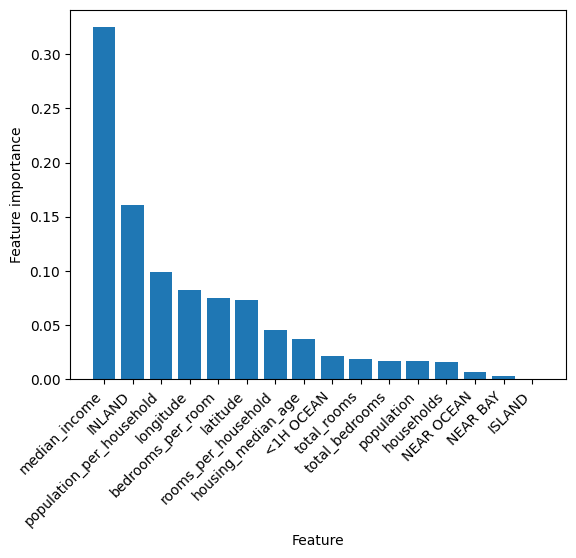

In [61]:
def plot_feature_importance(feature_importances, feature_names, threshold = None):
    df = pd.DataFrame.from_dict({
        "feature_importance": feature_importances,
        "feature": feature_names
    }).set_index("feature").sort_values("feature_importance", ascending = False)

    if threshold is not None:
        df = df[df.feature_importance > threshold]

    plt.bar(
        df.index,
        df["feature_importance"],
    )

    plt.xlabel("Feature")
    plt.ylabel("Feature importance")

    plt.xticks(rotation=45, ha="right")

plot_feature_importance(feature_importances, all_features)
plt.show()

This result confirms what we initially suspected: that the median income is the most important feature to predict a district's median house value. Moreover, given this information, it may be worthwhile to drop some of the features with lower importance in a future iteration of the model. For instance, all of the ocean-proximity features are not particularly important, except for the "INLAND" category.

## Evaluating the Model's Performance

Let's evaluate the model's performance on the test set:

In [62]:
final_model = rnd_search.best_estimator_

X_test = housing_test.drop("median_house_value", axis=1)
y_test = housing_test["median_house_value"].copy()

X_test_preprocessed = full_pipeline.transform(X_test)

y_predict = final_model.predict(X_test_preprocessed)

# Compute RMSE
final_mse = mean_squared_error(y_test, y_predict)
final_rmse = np.sqrt(final_mse)

# Compute confidence interval
alpha = 0.05
squared_errors = (y_predict - y_test) ** 2

confidence_interval = np.sqrt(
    scipy.stats.t.interval(
        1-alpha,
        len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=scipy.stats.sem(squared_errors)
    )
)
confidence_interval_str = f"${confidence_interval[0]:.2f}, ${confidence_interval[1]:.2f}"

print(f"Final RMSE: ${final_rmse:.2f}; {(1-alpha)*100:.0f}% confidence interval: [{confidence_interval_str}]")

Final RMSE: $43716.32; 95% confidence interval: [$41700.32, $45643.37]


The performance on the test set is slightly worse than what we found through cross-validation (which had an RMSE of $43,463), but this is not too surprising given that the model has not seen the test data before.

Let's plot the model-predicted median house value vs the true median house value for the test set to understand what kind of errors the model is making. We'll display the median income per district using the marker colour:

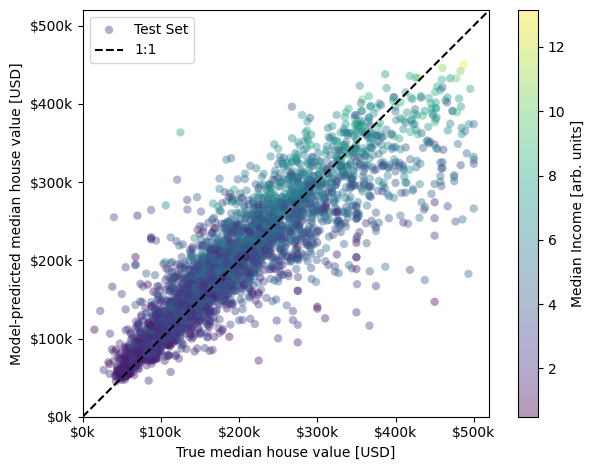

In [63]:
# In units of [1000 USD]
y_test_kusd = y_test * 0.001
y_predict_kusd = y_predict * 0.001

data_min = min(np.min(y_test_kusd), np.min(y_predict_kusd))
data_max = max(np.max(y_test_kusd), np.max(y_predict_kusd))

plt.scatter(y_test_kusd, y_predict_kusd, c=housing_test["median_income"], alpha=0.4, label="Test Set", edgecolors="None")
plt.colorbar(label="Median Income [arb. units]")

plt.xlabel("True median house value [USD]")
plt.ylabel("Model-predicted median house value [USD]")

margin = 20
plt.xlim(0, data_max + margin)
plt.ylim(0, data_max + margin)

plt.plot([0, data_max + margin], [0, data_max + margin], "k--", label="1:1")

ax = plt.gca()
ax.xaxis.set_major_formatter("${x:.0f}k")
ax.yaxis.set_major_formatter("${x:.0f}k")
ax.set_aspect("equal")

plt.legend()
plt.tight_layout()
plt.show()

We can see that the true and predicted values correlate well and mostly follow the 1:1 line, however there is a large amount of "noise" in this plot. In addition, for low house values, the model appears to over-predict by a few thousand dollars, while for high house values, the model tends to under-predict, in some cases by several $100k. It also appears that the model struggles especially with high median house values in districts with low median incomes, suggesting perhaps that there is some feature that we have missed that can account for this discrepancy.

Before we move on, let's compute the prediction error for each district and plot them as a histogram:

Mean prediction error = (6.05 +/- 0.49) %
Mean absolute prediction error = (16.72 +/- 0.41) %


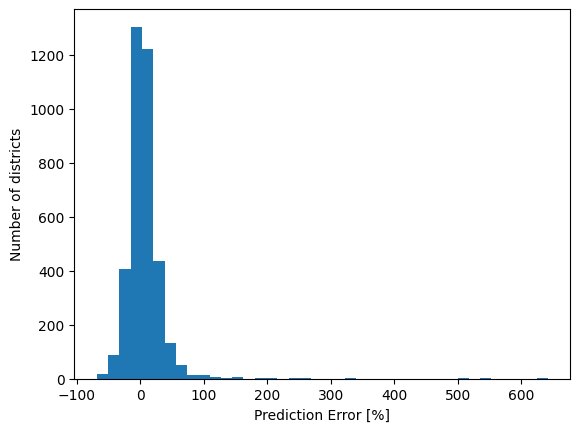

In [64]:
prediction_errors_percent = ((y_predict / y_test) - 1) * 100

prediction_error_mean = np.mean(prediction_errors_percent)
prediction_errors_stderr = scipy.stats.sem(prediction_errors_percent)
print(f"Mean prediction error = ({prediction_error_mean:.2f} +/- {prediction_errors_stderr:.2f}) %")

prediction_error_abs_mean = np.mean(np.abs(prediction_errors_percent))
prediction_errors_abs_stderr = scipy.stats.sem(np.abs(prediction_errors_percent))
print(f"Mean absolute prediction error = ({prediction_error_abs_mean:.2f} +/- {prediction_errors_abs_stderr:.2f}) %")

plt.hist(prediction_errors_percent, bins=40)
plt.xlabel("Prediction Error [%]")
plt.ylabel("Number of districts")
plt.show()

In the majority of cases, the absolute prediction error is on the order of 16.7%, which is slightly better than the experts' predictions, which were often off by more than 20%. However, the model is capable of making prediction errors of more than 100%, therefore we should be cautious of the predictions it makes.

## Save the Model for Use in Production

To use the model in production, we can save it to disk using the `joblib` package and then reload it when required:

In [65]:
import joblib

joblib.dump(final_model, "california_housing_model.pkl")

['california_housing_model.pkl']

We can now deploy the model and use it in production as follows:

```python
import joblib

california_housing_model = joblib.load("my_california_housing_model.pkl")

new_data = ...  # Data from new districts
predictions = california_housing_model.predict(new_data)
```

## Summary

In this project we have built a model to predict the median house values in California census block groups ("districts"), trained on data obtained from the 1990 California census. We trained three classes of candidate models:

* Linear regression
* SVM regressor
* Random forest regressor

We evaluated the models' performance using K-fold cross-validation with the root-mean-squared-error (RMSE) metric and found that the random forest regressor performed best (having the lowest RMSE). We fine-tuned the random forest regressor model using both a grid search and randomized search of a selected subset of its hyperparameters: n_estimators, max_features, and whether or not to use bootstrapping.

Once fully trained using the optimized hyperparameters, we found the model predicts the median house price with an RMSE of approximately $43,716 and a mean absolute prediction error of approximately 17%, outperforming the typical experts' prediction error of 20%.

We found that the district's median income was the best predictor of the median house value for this model, followed by the "inland" ocean-proximity feature, the population per household and the geographical location (longitude and latitude).

Given that the performance of the model is approximately on par with the experts' predictions, perhaps even slightly better, we recommend deploying this model (at least to free up some of the experts' valuable time!)